<a href="https://colab.research.google.com/github/Euan-J-Austin/Analytics_and_Intelligence/blob/main/ProphetNotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prophet

Forecasting

Predicting future traffic for Udemy Wiki page

Error is a part of prediction, trying to explain all variation will result in overfitting

Uses Stan, a probabilisitic programming language for statistical causal inference, writtin in C++

Built-in cross-validation

#Time series

Data for consecutive periods

Many concepts and algorithms dealing with time series e.g. Structural Time series which decomposes data, at least, down to  seasonality, trend, exogenous impacts (e.g. weather, economic sentiment), and error term

*y(t) = c(t) + s(t) + x(t) + ε* `

# Prophet's methodological framework

*y(t) = c(t) + s(t) + h(t) + x(t) + ε*

1. c(t) ... Trend
2. s(t) ... Seasonality
3. h(t) ... Holiday effects +
4. x(t) ... External regressors + (not same as holidays, only impacts the day itself)
5. ε ... error, to be minimised




# Udemy practice case study

In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet

# Data

In [3]:
df = pd.read_csv('/content/Udemy_wikipedia_visits.csv')

In [5]:
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,01/01/2016,311,0,0,0
1,01/02/2016,564,0,0,0
2,01/03/2016,517,0,0,0
3,01/04/2016,652,0,0,0
4,01/05/2016,756,0,0,0


In [9]:
df.describe()

,Udemy,Easter,Christmas,Black Friday
count,1827.000000,1827.000000,1827.000000,1827.000000
mean,943.068418,0.002737,0.002737,0.002737
std,531.341700,0.052256,0.052256,0.052256
min,209.000000,0.000000,0.000000,0.000000
25%,542.500000,0.000000,0.000000,0.000000
50%,832.000000,0.000000,0.000000,0.000000
75%,1175.000000,0.000000,0.000000,0.000000
max,2847.000000,1.000000,1.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          1827 non-null   object
 1   Udemy         1827 non-null   int64 
 2   Easter        1827 non-null   int64 
 3   Christmas     1827 non-null   int64 
 4   Black Friday  1827 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.5+ KB


<Axes: >

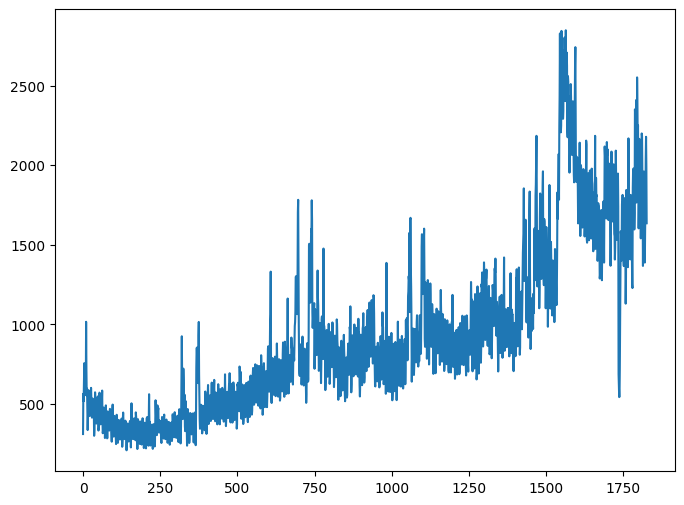

In [12]:
df.Udemy.plot(figsize = (8, 6))

## Data formatting

### Date variable

In [14]:
# %m/%d/%Y -- we want --> %Y-%m-%d
df.Date

0       01/01/2016
1       01/02/2016
2       01/03/2016
3       01/04/2016
4       01/05/2016
           ...    
1822    12/27/2020
1823    12/28/2020
1824    12/29/2020
1825    12/30/2020
1826    12/31/2020
Name: Date, Length: 1827, dtype: object

In [18]:
df.Date = pd.to_datetime(df.Date,
                         format = '%m/%d/%Y')
df.Date

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
          ...    
1822   2020-12-27
1823   2020-12-28
1824   2020-12-29
1825   2020-12-30
1826   2020-12-31
Name: Date, Length: 1827, dtype: datetime64[ns]

### Renaming variables

In [28]:
#Date --> ds, ... time-series (Udemy) -> y

df = df.rename(columns = {'Date': 'ds',
                          'Udemy': 'y',
                          'Black Friday': 'BlackFriday'})
df.head(3)

,ds,y,Easter,Christmas,BlackFriday
0,2016-01-01,311,0,0,0
1,2016-01-02,564,0,0,0
2,2016-01-03,517,0,0,0


## Dynamic holidays

### Valentine's example

With Prophet, specify XXXX-02-14 as a key event and specifing days before and after

For other models, would have to create a dummy variable for each day

### Easter holiday

In [22]:
easter_dates = df[df.Easter == 1].ds

In [23]:
easter_dates

86     2016-03-27
471    2017-04-16
821    2018-04-01
1206   2019-04-21
1563   2020-04-12
Name: ds, dtype: datetime64[ns]

In [25]:
easter = pd.DataFrame({
    'holiday': 'easter',
    'ds': easter_dates,
    'lower_window': -5,
    'upper_window': 2})

easter

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2


### Black Friday holiday

In [31]:
blackfriday = pd.DataFrame({
    'holiday': 'BlackFriday',
    'ds': df[df.BlackFriday == 1].ds,
    'lower_window': -7,
    'upper_window': 5})

#Udemy's promotional period

In [32]:
blackfriday

,holiday,ds,lower_window,upper_window
329,BlackFriday,2016-11-25,-7,5
693,BlackFriday,2017-11-24,-7,5
1057,BlackFriday,2018-11-23,-7,5
1428,BlackFriday,2019-11-29,-7,5
1792,BlackFriday,2020-11-27,-7,5


### Combining holidays' DataFrames

In [36]:
holidays = pd.concat([easter, blackfriday])

In [37]:
holidays

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2
329,BlackFriday,2016-11-25,-7,5
693,BlackFriday,2017-11-24,-7,5
1057,BlackFriday,2018-11-23,-7,5
1428,BlackFriday,2019-11-29,-7,5
1792,BlackFriday,2020-11-27,-7,5


### Remove holidays from DataFrame

In [38]:
df = df.drop(columns = ['Easter', 'BlackFriday'])
df.head(0)

,ds,y,Christmas


# Training and Test sets in Time Series

Can't be randomly selected because days need to have context of the days surrounding

We want to predict the future, so focus wish to focus on most recent dates

So, early dates are used for training and most recent for test ...

You should be measured for the number of periods you wish to predict e.g. if predicting sales in 4 weeks, divide time series into 4 week periods

## Training and Test Split

In [39]:
test_days = 31
training = df.iloc[:-test_days,:]
test = df.iloc[-test_days:,:]

In [40]:
print(test.head(1))

             ds     y  Christmas
1796 2020-12-01  2393          0


In [42]:
print(training.tail(1))

             ds     y  Christmas
1795 2020-11-30  2551          0
